In [1]:
import fun as f
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
import scipy.linalg as la
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from IPython.display import Image

# 1- Half-moon Dataset:

In [2]:
#Generate data
Npts = 35
half_moons_data = datasets.make_moons(n_samples=Npts, noise=.040, random_state=1991)
nodes_position = dict()
for key  in [i for i in range(Npts)]:
    nodes_position[key] = list(half_moons_data[0][key])

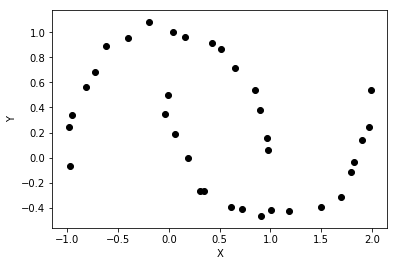

In [3]:
#plot data
f.scatter_plot_data_set(half_moons_data[0], half_moons_data[1], "figures/00-two_half_moons", False)

## i) Fully connected graph 

In [4]:
small_sigma = 0.05
W_half_moon = f.adjacency_matrix(half_moons_data[0], sigma=small_sigma)

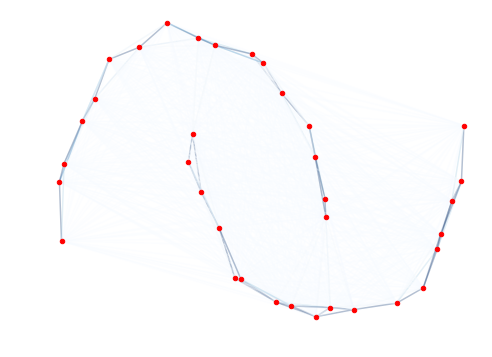

In [6]:
#create graph
hm = f.create_weighted_Graph(W_half_moon)
#Plot graph
f.plot_Graph(hm, nodes_position, title = '',alpha=0.3, output_file_name="fully_connected_graph")

In [7]:
#Unnormalized
Image(url='gif.gif')

In [8]:
#Unnormalized graph Laplacian
eigenvalues_unnorm_m, eigenvectors_unnorm_m = la.eig(f.unnormalized_graph_Laplacian(W_half_moon))
eigenvalues_unnorm_m = eigenvalues_unnorm_m.real
rearranged_unnorm_evals_moon_data = f.rearrange_eigenvals(eigenvalues_unnorm_m, eigenvectors_unnorm_m)
rearranged_unnorm_vecs_moon_data = f.rearrange_eigenvecs(rearranged_unnorm_evals_moon_data,
                                                      half_moons_data[1])

#Symmetric graph Laplacian
eigenvalues_sym_m, eigenvectors_sym_m = la.eig(f.normalized_graph_Laplacian(W_half_moon,matrix ="symmetric"))
eigenvalues_sym_m = eigenvalues_sym_m.real
rearranged_sym_evals_moon_data = f.rearrange_eigenvals(eigenvalues_sym_m, eigenvectors_sym_m)
rearranged_sym_vecs_moon_data = f.rearrange_eigenvecs(rearranged_sym_evals_moon_data,
                                                       half_moons_data[1])

##Random Walk graph Laplacian   
eigenvalues_rw_m, eigenvectors_rw_m = la.eig(f.normalized_graph_Laplacian(W_half_moon, matrix ="rw"))
eigenvalues_rw_m = eigenvalues_rw_m.real
rearranged_rw_evals_moon_data = f.rearrange_eigenvals(eigenvalues_rw_m, eigenvectors_rw_m)
rearranged_rw_vecs_moon_data = f.rearrange_eigenvecs(rearranged_rw_evals_moon_data,
                                                       half_moons_data[1])



In [9]:
ylim_list =[(0.05, 0.22), (-0.3, 0.3), (-0.35, 0.3), (-0.4, 0.4)]
titles_list = ["Unnormalized","Random Walk","Symmetric"]
eigenvectors_sorted_lists = f.eigenvectors_list([rearranged_unnorm_vecs_moon_data,
                                               rearranged_rw_vecs_moon_data,
                                               rearranged_sym_vecs_moon_data])
eigenvalues_sorted_lists = f.eigenvalues_list([rearranged_unnorm_evals_moon_data,
                                               rearranged_rw_evals_moon_data,
                                               rearranged_sym_evals_moon_data])

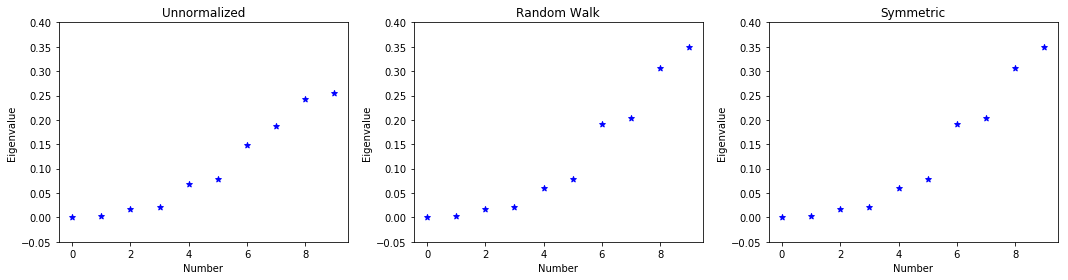

In [10]:
ylim_list =[(-0.05, 0.4), (-0.05, 0.4), (-0.05, 0.4), (-0.05, 0.4)]
f.plot_eigenvalues(eigenvalues_sorted_lists, titles_list,
                   ylim_list, "figures/11-eigenvalues_halfmoons",n=10)

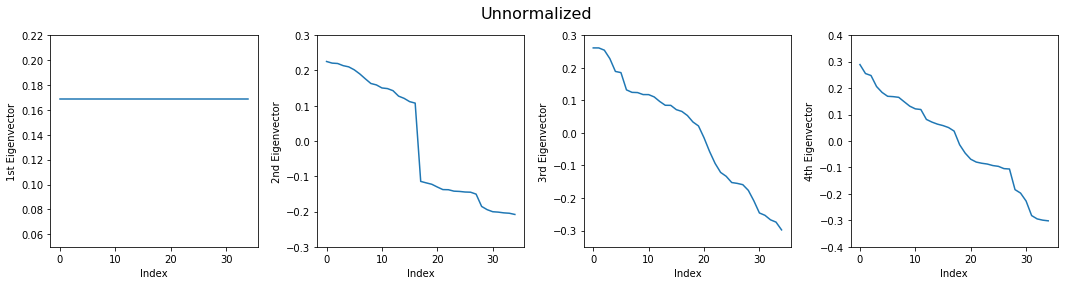

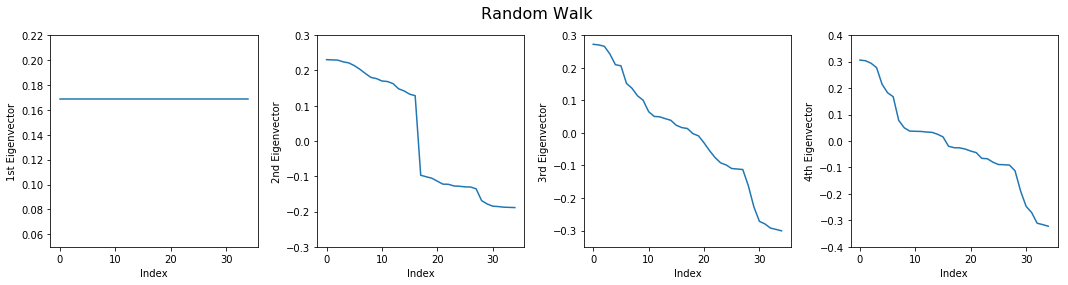

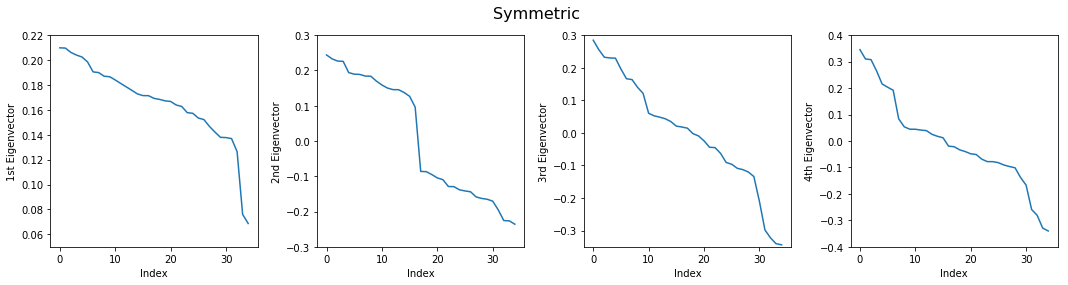

In [11]:
ylim_list =[(0.05, 0.22), (-0.3, 0.3), (-0.35, 0.3), (-0.4, 0.4)]
f.plot_eigenvectors(titles_list, eigenvectors_sorted_lists, 
                    ylim_list, "figures/12-line_plot", plot_type="plot")
#f.plot_eigenvectors(titles_list, eigenvectors_list, ylim_list, "figures/test", plot_type="scatter")

## The algorithms

In [12]:
#K-means performance before the change of representation of the data:
kmeans_moon_data_coord = KMeans(n_clusters=2,random_state=0).fit(half_moons_data[0])

#K-means performance after performing spectral clustering:
c_unnormalized = f.spectral_clustering_algorithm(rearranged_unnorm_evals_moon_data, 2, which="unnormalized")
c_rw = f.spectral_clustering_algorithm(rearranged_rw_evals_moon_data, 2, which="normalized_rw")
c_sym = f.spectral_clustering_algorithm(rearranged_sym_evals_moon_data, 2, which="normalized_sym")

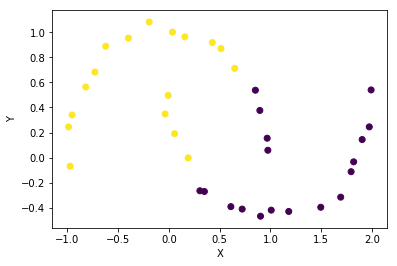

In [13]:
x, y = half_moons_data[0].T
plt.scatter(x,y,c=kmeans_moon_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("figures/13-kmeans_moon_data")
plt.show()

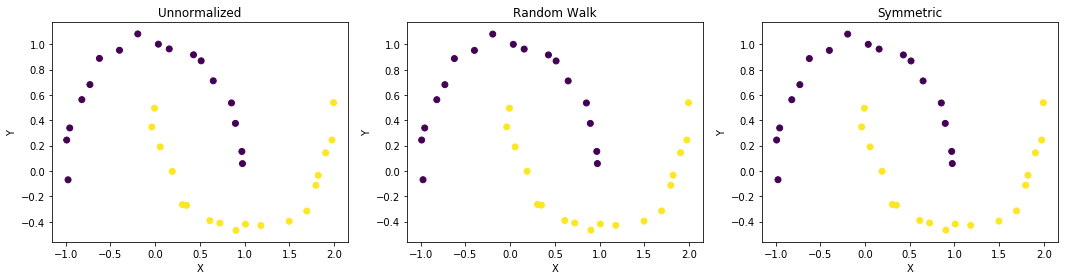

In [14]:
f.plot_kmeans_clustering(x,y,titles_list,[c_unnormalized, c_rw, c_sym],"figures/14-sc_moon_data")

## Sensitivity to parameter selection

In [15]:
large_sigma = 0.1
W_half_moon_large_sigma = f.adjacency_matrix(half_moons_data[0], sigma=large_sigma)


#Unnormalized graph Laplacian
eigenvalues_unnorm_ls, eigenvectors_unnorm_ls = la.eig(f.unnormalized_graph_Laplacian(W_half_moon_large_sigma))
eigenvalues_unnorm_ls = eigenvalues_unnorm_ls.real
rearranged_unnorm_evals_ls = f.rearrange_eigenvals(eigenvalues_unnorm_ls, eigenvectors_unnorm_ls)
rearranged_unnorm_vecs_ls = f.rearrange_eigenvecs(rearranged_unnorm_evals_ls, half_moons_data[1])

#Symmetric graph Laplacian
eigenvalues_sym_ls, eigenvectors_sym_ls = la.eig(f.normalized_graph_Laplacian(W_half_moon_large_sigma,
                                                                              matrix ="symmetric"))
eigenvalues_sym_ls = eigenvalues_sym_ls.real
rearranged_sym_evals_ls = f.rearrange_eigenvals(eigenvalues_sym_ls, eigenvectors_sym_ls)
rearranged_sym_vecs_ls = f.rearrange_eigenvecs(rearranged_sym_evals_ls, half_moons_data[1])

##Random Walk graph Laplacian   
eigenvalues_rw_ls, eigenvectors_rw_ls = la.eig(f.normalized_graph_Laplacian(W_half_moon_large_sigma,
                                                                            matrix ="rw"))
eigenvalues_rw_ls = eigenvalues_rw_ls.real
rearranged_rw_evals_ls = f.rearrange_eigenvals(eigenvalues_rw_ls, eigenvectors_rw_ls)
rearranged_rw_vecs_ls = f.rearrange_eigenvecs(rearranged_rw_evals_ls, half_moons_data[1])



In [16]:
ylim_list_ls =[(-0.05, 0.9), (-0.05, 0.65), (-0.05, 0.65)]
eigenvectors_list_ls = f.eigenvectors_list([rearranged_unnorm_vecs_ls,
                                               rearranged_rw_vecs_ls,
                                               rearranged_sym_vecs_ls])

eigenvalues_list_ls = f.eigenvalues_list([rearranged_unnorm_evals_ls,
                                               rearranged_rw_evals_ls,
                                               rearranged_sym_evals_ls])

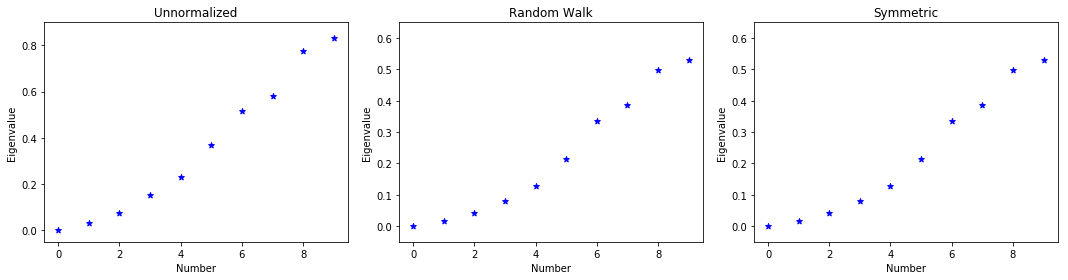

In [17]:
f.plot_eigenvalues(eigenvalues_list_ls, titles_list, ylim_list_ls, "figures/61-large_sigma_eigenspectrum", n=10)

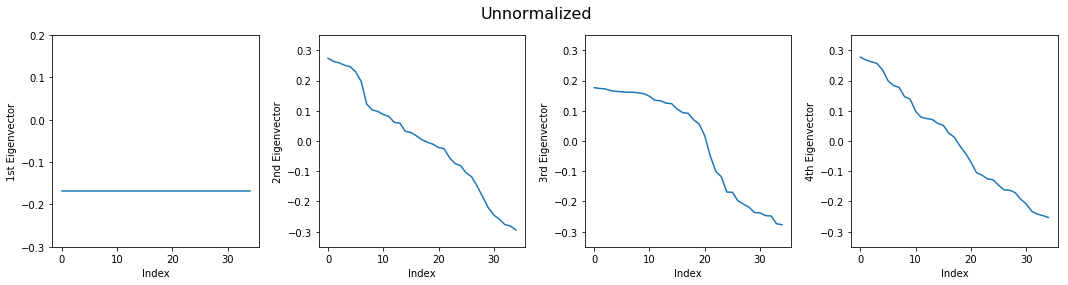

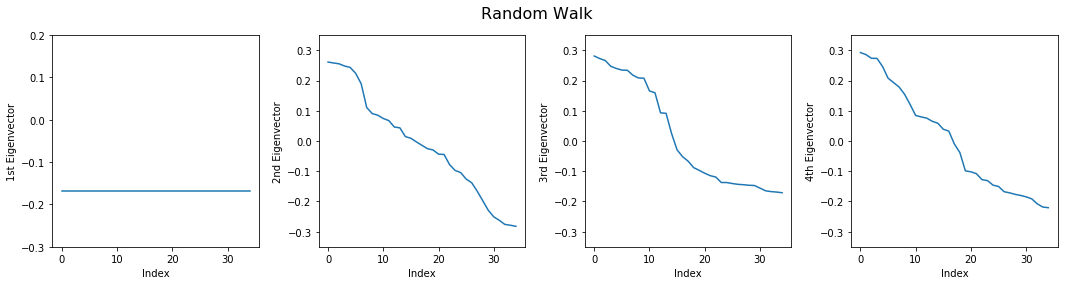

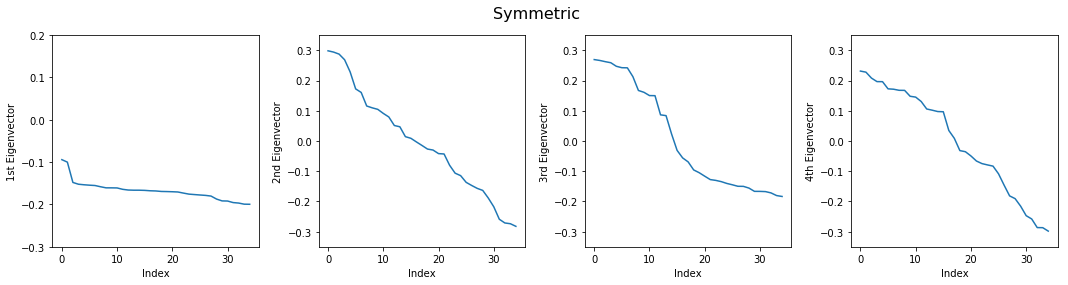

In [18]:
ylim_list =[(-0.3, 0.2), (-0.35, 0.35), (-0.35, 0.35), (-0.35, 0.35)]
f.plot_eigenvectors(titles_list, eigenvectors_list_ls, ylim_list, "figures/62-line_plot_ls", plot_type="plot")
#f.plot_eigenvectors(titles_list, eigenvectors_list, ylim_list, "figures/test", plot_type="scatter")

# 2- Spiral Dataset

In [19]:
# Toy dataset obtained from:
# https://www.gagolewski.com/resources/data/clustering/
data_path = 'data/spiral.data'
labels_path = 'data/spiral.labels'

In [20]:
data_points, data_labels = f.read_and_convert_data(data_path, labels_path)
Npts, coord = data_points.shape
nodes_position_spiral = dict()
for key  in [i for i in range(Npts)]:
    nodes_position_spiral[key] = list(data_points[key])
    
W_spiral = f.adjacency_matrix(data_points, sigma=0.5)

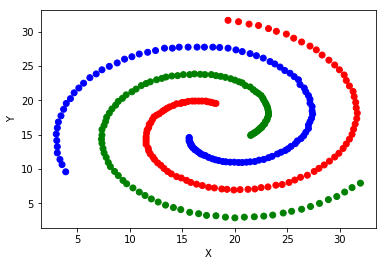

In [21]:
f.scatter_plot_data_set(data_points, data_labels,"figures/01-spiral_data")

In [22]:
# #create graph
# spiral_graph = f.create_weighted_Graph(W_spiral)
# #Plot graph
# f.plot_Graph(spiral_graph, nodes_position_spiral, 
#                title = '',node_size=5,edge_vmax=1e-8,alpha=0.2)

## Compute eigenvalues-eigenvectors

In [23]:
#Unnormalized graph Laplacian
eigenvalues_unnorm_s, eigenvectors_unnorm_s = la.eig(f.unnormalized_graph_Laplacian(W_spiral))
eigenvalues_unnorm_s = eigenvalues_unnorm_s.real
rearranged_unnorm_evals_spiral_data = f.rearrange_eigenvals(eigenvalues_unnorm_s, eigenvectors_unnorm_s)
rearranged_unnorm_vecs_spiral_data = f.rearrange_eigenvecs(rearranged_unnorm_evals_spiral_data, data_labels)

#Symmetric graph Laplacian
eigenvalues_sym_s, eigenvectors_sym_s = la.eig(f.normalized_graph_Laplacian(W_spiral, matrix ="symmetric"))
eigenvalues_sym_s = eigenvalues_sym_s.real
rearranged_sym_evals_spiral_data = f.rearrange_eigenvals(eigenvalues_sym_s, eigenvectors_sym_s)
rearranged_sym_vecs_spiral_data = f.rearrange_eigenvecs(rearranged_sym_evals_spiral_data, data_labels)

##Random Walk graph Laplacian   
eigenvalues_rw_s, eigenvectors_rw_s = la.eig(f.normalized_graph_Laplacian(W_spiral, matrix ="rw"))
eigenvalues_rw_s = eigenvalues_rw_s.real
rearranged_rw_evals_spiral_data = f.rearrange_eigenvals(eigenvalues_rw_s, eigenvectors_rw_s)
rearranged_rw_vecs_spiral_data = f.rearrange_eigenvecs(rearranged_rw_evals_spiral_data, data_labels)

In [24]:
eigenvectors_list_s = f.eigenvectors_list([rearranged_unnorm_vecs_spiral_data,
                                               rearranged_rw_vecs_spiral_data,
                                               rearranged_sym_vecs_spiral_data])

eigenvalues_list_s = f.eigenvalues_list([rearranged_unnorm_evals_spiral_data,
                                               rearranged_rw_evals_spiral_data,
                                               rearranged_sym_evals_spiral_data])

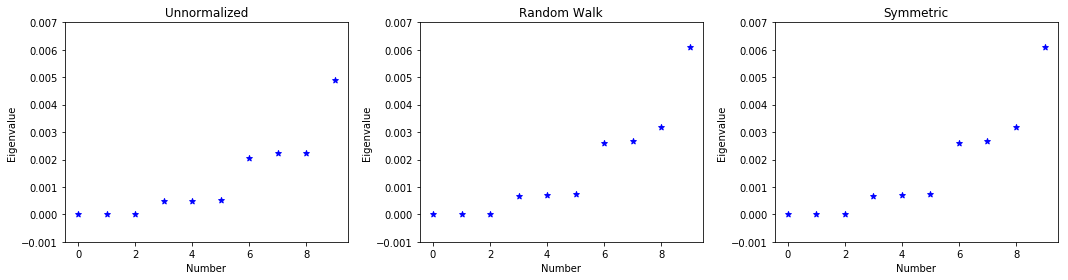

In [25]:
ylim_list =[(-0.001, 0.007), (-0.001, 0.007), (-0.001, 0.007), (-0.001, 0.007)]
f.plot_eigenvalues(eigenvalues_list_s, titles_list,
                   ylim_list, "figures/22-eigenvalues_spiral_data", n=10)

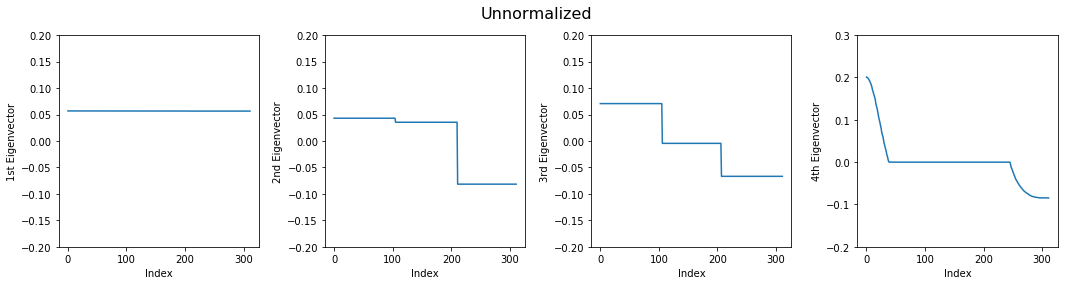

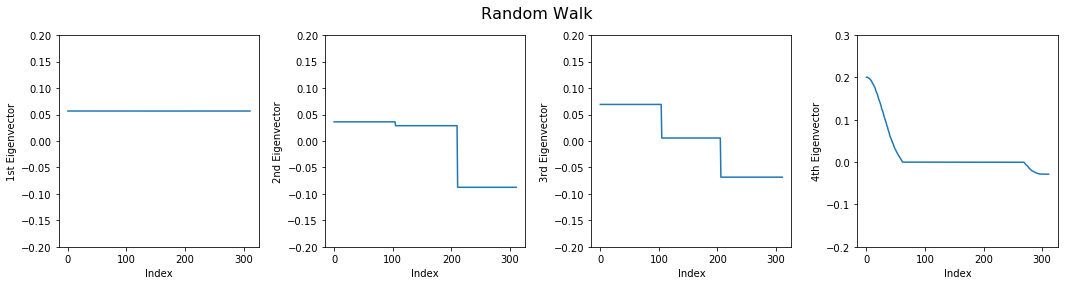

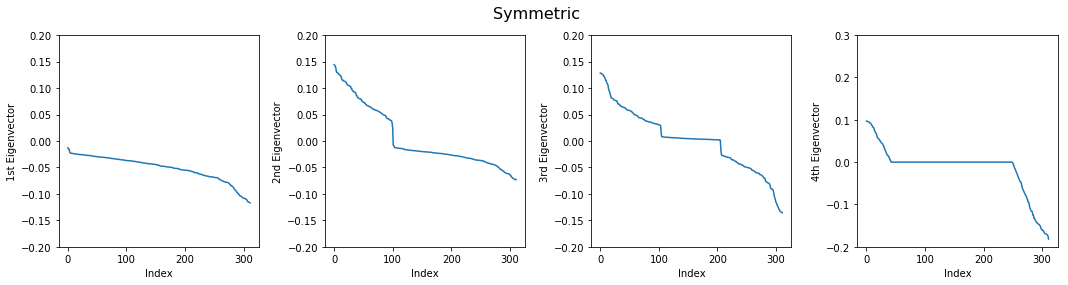

In [26]:
ylim_list =[(-0.2, 0.2), (-0.2, 0.2), (-0.2, 0.2), (-0.2, 0.3)]
f.plot_eigenvectors(titles_list, eigenvectors_list_s,
                    ylim_list, "figures/23-line_plot_spiral", plot_type="plot")
#f.plot_eigenvectors(titles_list, eigenvectors_list, ylim_list, "figures/test", plot_type="scatter")

### Multiplicity of the first eigenvalue

In [27]:
print(np.where(eigenvalues_unnorm_s < 1e-8)[0].shape[0])
print(np.where(eigenvalues_sym_s < 1e-8)[0].shape[0])
print(np.where(eigenvalues_rw_s < 1e-8)[0].shape[0])

3
3
3


Given that the multiplicity of the smallest eigenvalue is 3, we can notice from the plot below, that in practice these three eigenvalues are very close to zero but not exactly zero, because as we are working with a fully  connected graph with self-connectivited weights obtained by the Gaussian Function, there will still be a very weak connection between some nodes.

 We can also notice that there is a big jump between  the 3rd and 4rth node which clearly defines the presence of 3 clusters in our data.

### In the second and third eigenvectors, why do we move from one to two steps?
### Why does the projection of the 2nd 3rd eigenvector components are overlap into a single point?
### How about the rest of eigenvectors?

Notice that the elements of the first eigenvector are all aligned in the same y-axis, defining a single component,  in the case of the second eigenvector we can see that the elements are divided by a step defining 2 componenets, while in the case of the third eigenvector, we now have two steps that divides the elements of the eigenvector into three components.

If we now project the 3rd eigenvector into the 2nd eigenvector, we can notice that all points overlap, giving the impression of looking at a single point. The projection of the 3rd and 2nd eigenvector offers a new representation of the data that crearly and accurately divides the clusters in our data. Hence, applying k-means or any other clustering algorithm to our new data coordinates will now excel in campturing the geometrical structure of the data.

 The figure below plots the eigenvector elements, each corresponding to an element of the graph, with respect to the element index. They are arranged in increasing order according to the the unnormalized graph Laplacian eigenspectrum.
 
If we keep looking into further eigenvectors we can see that the elements do not follow this same step behaviour, i.e the fourth eigenvector do not define 4 components (also $\lambda_4 > 1e-8$), and so on.


In [28]:
rearranged_evals_list = [rearranged_unnorm_evals_spiral_data, 
                         rearranged_rw_evals_spiral_data,
                        rearranged_sym_evals_spiral_data]


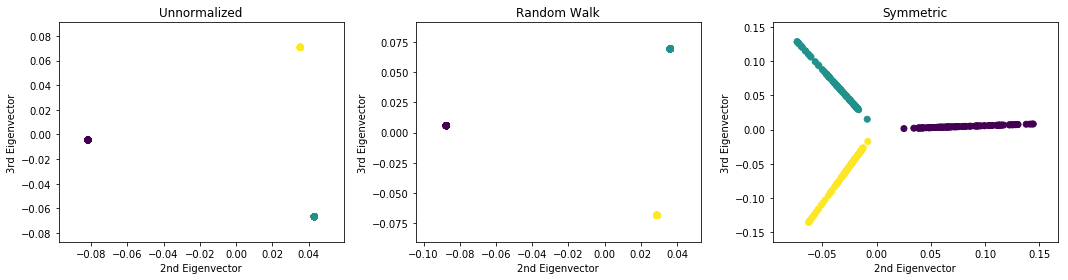

In [29]:
f. plot_eigenvectors_proj(rearranged_evals_list, data_labels, titles_list, "figures/26-projection_spiral")

In [30]:
#K-means performance before the change of representation of the data:
k=3
kmeans_spiral_data_coord = KMeans(n_clusters=3,random_state=0).fit(data_points)

#K-means performance after performing spectral clustering:

s_unnormalized = f.spectral_clustering_algorithm(rearranged_unnorm_evals_spiral_data, k, which="unnormalized")
s_rw = f.spectral_clustering_algorithm(rearranged_rw_evals_spiral_data, k, which="normalized_rw")
s_sym = f.spectral_clustering_algorithm(rearranged_sym_evals_spiral_data, k, which="normalized_sym")

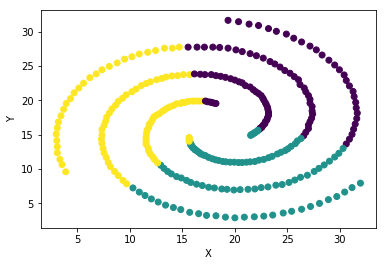

In [31]:
x, y = data_points.T
plt.scatter(x,y,c=kmeans_spiral_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("figures/27-kmeans_spiral_data")
plt.show()

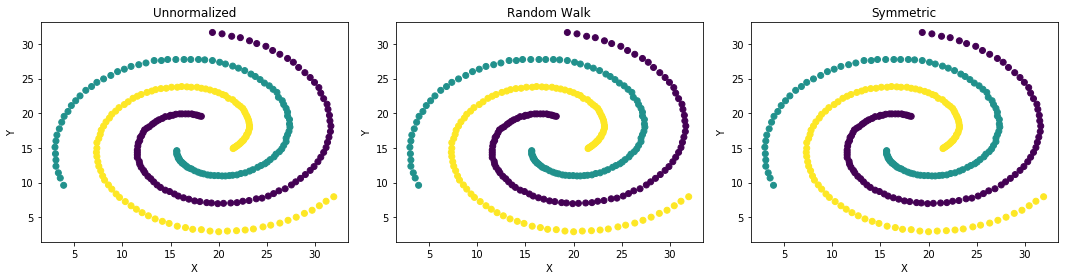

In [32]:
f.plot_kmeans_clustering(x,y,titles_list,[s_unnormalized, s_rw, s_sym],"figures/28-kmeans_spiral_data")

## 3- Circles data set

In [33]:
# Generate data set:
Npts_list = [400, 250, 70]
rad_list = [10, 6, 2]
lower_boundry_list=[0.7, 0.5, 0.3]
circle_data_points = f.generate_3circles_data_set(Npts_list, rad_list,lower_boundry_list, seed=1991)

### Multiplicity of the first eigenvalue

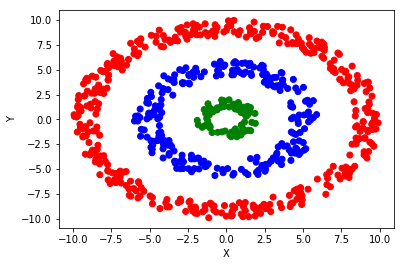

In [34]:
#Plot the data with original labels
f.scatter_plot_data_set(circle_data_points[:,0:2], circle_data_points[:,2], "figures/04-circle_data")

In [35]:
#Generate adjacency matrix:
W_circles_dataset = f.adjacency_matrix(circle_data_points[:,0:2], sigma=1)

#Unnormalized graph Laplacian
eigenvalues_unnorm_c, eigenvectors_unnorm_c = la.eig(f.unnormalized_graph_Laplacian(W_circles_dataset))
eigenvalues_unnorm_c = eigenvalues_unnorm_c.real
rearranged_unnorm_evals_circle_data = f.rearrange_eigenvals(eigenvalues_unnorm_c, eigenvectors_unnorm_c)
rearranged_unnorm_vecs_circle_data = f.rearrange_eigenvecs(rearranged_unnorm_evals_circle_data, 
                                                           circle_data_points[:,2])
#Symmetric graph Laplacian
eigenvalues_sym_c, eigenvectors_sym_c = la.eig(f.normalized_graph_Laplacian(W_circles_dataset,
                                                                            matrix ="symmetric"))
eigenvalues_sym_c = eigenvalues_sym_c.real
rearranged_sym_evals_circle_data = f.rearrange_eigenvals(eigenvalues_sym_c, eigenvectors_sym_c)
rearranged_sym_vecs_circle_data = f.rearrange_eigenvecs(rearranged_sym_evals_circle_data, 
                                                        circle_data_points[:,2])

##Random Walk graph Laplacian   
eigenvalues_rw_c, eigenvectors_rw_c = la.eig(f.normalized_graph_Laplacian(W_circles_dataset,
                                                                          matrix ="rw"))
eigenvalues_rw_c = eigenvalues_rw_c.real
rearranged_rw_evals_circle_data = f.rearrange_eigenvals(eigenvalues_rw_c, eigenvectors_rw_c)
rearranged_rw_vecs_circle_data = f.rearrange_eigenvecs(rearranged_rw_evals_circle_data,
                                                       circle_data_points[:,2])

In [36]:
#Determine the number of clusters
multiplicity_k = np.where(eigenvalues_unnorm_c < 1e-2)[0].shape[0]
multiplicity_k

3

In [37]:
ylim_list =[(-0.025, 0.175), (-0.005, 0.02), (-0.005, 0.02)]
eigenvectors_list_circ = f.eigenvectors_list([rearranged_unnorm_vecs_circle_data,
                                               rearranged_rw_vecs_circle_data,
                                               rearranged_sym_vecs_circle_data])

eigenvalues_list_circ = f.eigenvalues_list([rearranged_unnorm_evals_circle_data,
                                               rearranged_rw_evals_circle_data,
                                               rearranged_sym_evals_circle_data])

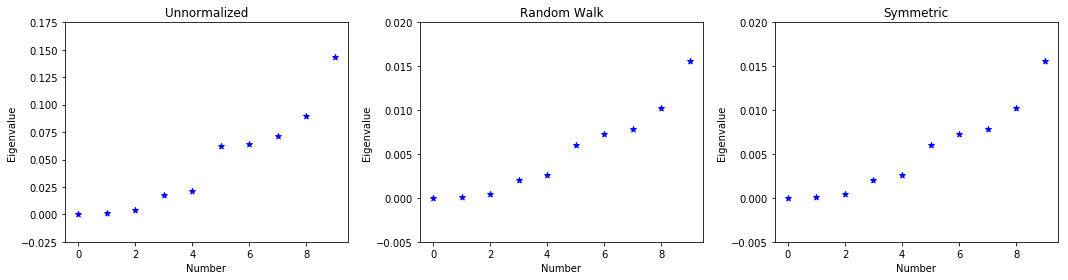

In [38]:
f.plot_eigenvalues(eigenvalues_list_circ, titles_list,
                   ylim_list, "figures/44-eigenvalues_circle_data", n=10)

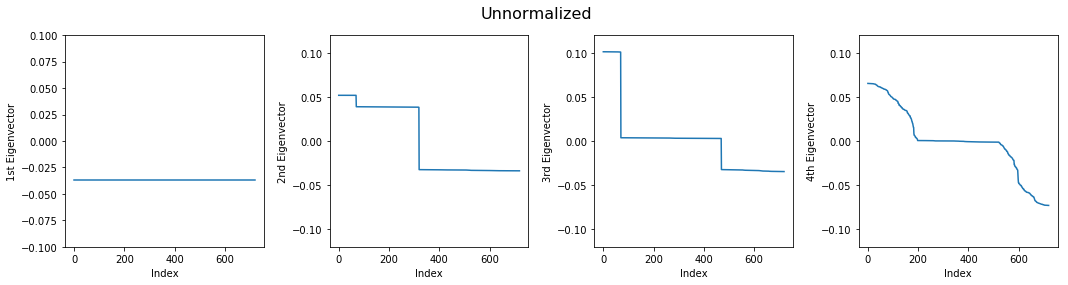

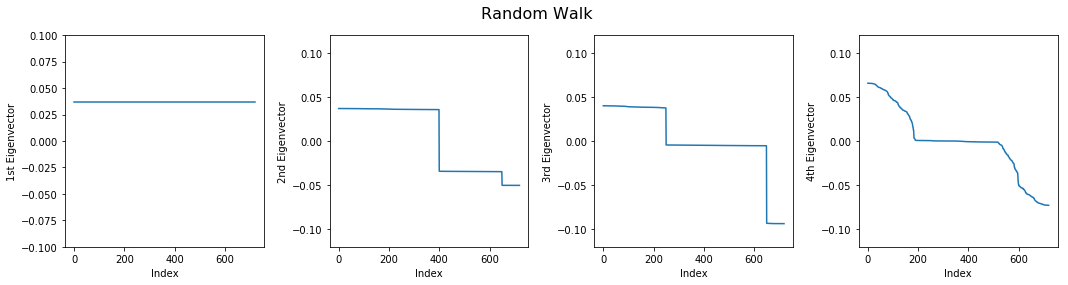

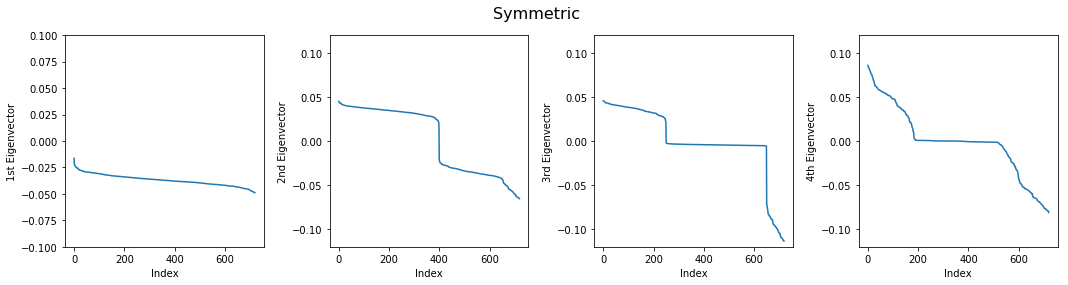

In [39]:
ylim_list =[(-0.1, 0.1), (-0.12, 0.12), (-0.12, 0.12), (-0.12, 0.12)]
f.plot_eigenvectors(titles_list, eigenvectors_list_circ,
                    ylim_list, "figures/45-line_plot_circle", plot_type="plot")

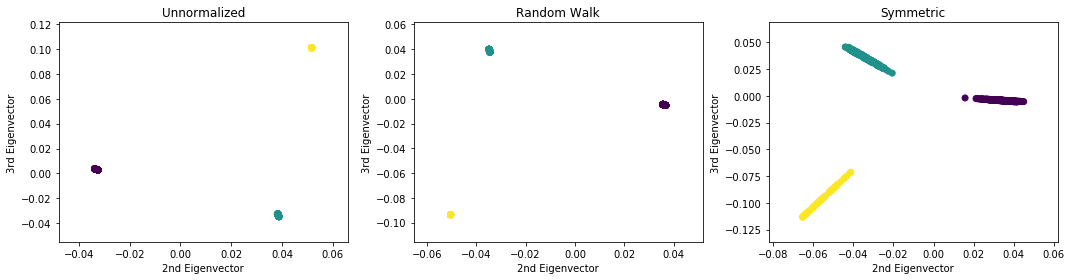

In [40]:
rearranged_evals_list_circle = [rearranged_unnorm_evals_circle_data, 
                         rearranged_rw_evals_circle_data,
                        rearranged_sym_evals_circle_data]

f. plot_eigenvectors_proj(rearranged_evals_list_circle, circle_data_points[:,2],
                          titles_list, "figures/46-projection_circle")

# The algorithm:

In [41]:
#K-means performance before the change of representation of the data:
k=3
kmeans_circle_data_coord = KMeans(n_clusters=k,random_state=0).fit(circle_data_points[:,0:2])

#K-means performance after performing spectral clustering:

cir_unnormalized = f.spectral_clustering_algorithm(rearranged_unnorm_evals_circle_data, k, which="unnormalized")
cir_rw = f.spectral_clustering_algorithm(rearranged_rw_evals_circle_data, k, which="normalized_rw")
cir_sym = f.spectral_clustering_algorithm(rearranged_sym_evals_circle_data, k, which="normalized_sym")

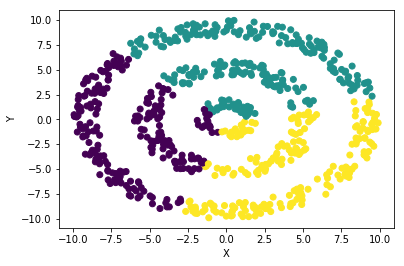

In [42]:
#Using K-means
x, y,z = circle_data_points.T

plt.tight_layout()
plt.scatter(x,y,c=kmeans_circle_data_coord.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("figures/47-kmeans_circle_data")
plt.show()

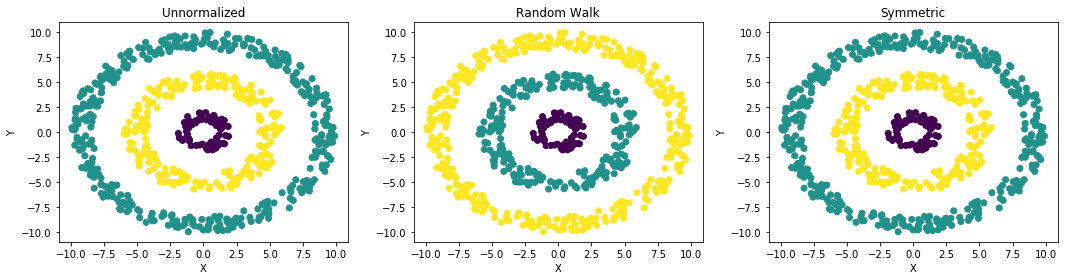

In [43]:
f.plot_kmeans_clustering(x,y,titles_list,[cir_unnormalized, cir_rw, cir_sym], "figures/48-kmeans_circle_data")

## Validation

## Pearson correlation coefficient with a *similarity matrix* defined by the Euclidean distance:

In [44]:
incidence_matrix = f.incidence_matrix(z)
similarity_matrix_eucledian_d = f.distance_matrix(circle_data_points[:,0:2], "eucledian_dist")

In [45]:
f.correlation_coefficient(incidence_matrix, similarity_matrix_eucledian_d)

0.09362574783855335

## Pearson correlation coefficient with a *similarity matrix* defined by the Euclidean Commute Time Distance:

In [46]:
# similarity_matrix_CTD = f.distance_matrix(dic_EvalsEvecs_circle_data,
#                                           "commute_time_distance", W_circles_dataset)
# f.correlation_coefficient(incidence_matrix, similarity_matrix_CTD)

## A. Imbalanced data set

In [47]:
#Create data points
Npts_imb = 60
Nclusters = 2
np.random.seed(7)
data_coordinates = np.random.normal(loc=0.0, scale=1.0, size=(Npts_imb, 2))

#Assign randomly each datapoint to a cluster
labels = np.random.choice(list(range(Nclusters)),size=Npts_imb,replace=True, p=[0.15,0.85])

#Assign each cluster a mean.
data_means = np.zeros((2,2))
data_means[0,] = [6,5]
data_means[1,] = [11,6]
#Shift the points towards the mean
clusterd_data =data_coordinates+data_means[labels,]

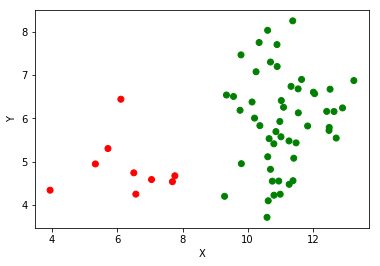

In [48]:
#Plot the data
f.scatter_plot_data_set(clusterd_data, labels, "figures/06-imb_data")

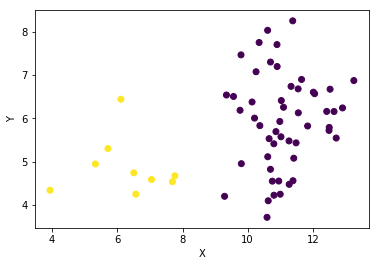

In [50]:
#K-means performance before the change of representation of the data:
kmeans_imbalanced_data = KMeans(n_clusters=2,random_state=0).fit(clusterd_data)

plt.scatter(clusterd_data[:,0],clusterd_data[:,1],c=kmeans_imbalanced_data.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [51]:
W_imbalanced_data = f.adjacency_matrix(clusterd_data, sigma=2)

#Unnormalized graph Laplacian
eigenvalues_unnorm_i, eigenvectors_unnorm_i = la.eig(f.unnormalized_graph_Laplacian(W_imbalanced_data))
eigenvalues_unnorm_i = eigenvalues_unnorm_i.real
rearranged_unnorm_evals_imb_data = f.rearrange_eigenvals(eigenvalues_unnorm_i, eigenvectors_unnorm_i)
rearranged_unnorm_vecs_imb_data = f.rearrange_eigenvecs(rearranged_unnorm_evals_imb_data, labels)
#Symmetric graph Laplacian
eigenvalues_sym_i, eigenvectors_sym_i = la.eig(f.normalized_graph_Laplacian(W_imbalanced_data, 
                                                                            matrix ="symmetric"))
eigenvalues_sym_i = eigenvalues_sym_i.real
rearranged_sym_evals_imb_data = f.rearrange_eigenvals(eigenvalues_sym_i, eigenvectors_sym_i)
rearranged_sym_vecs_imb_data = f.rearrange_eigenvecs(rearranged_sym_evals_imb_data, labels)

##Random Walk graph Laplacian   
eigenvalues_rw_i, eigenvectors_rw_i = la.eig(f.normalized_graph_Laplacian(W_imbalanced_data,
                                                                          matrix ="rw"))
eigenvalues_rw_i = eigenvalues_rw_i.real
rearranged_rw_evals_imb_data = f.rearrange_eigenvals(eigenvalues_rw_i, eigenvectors_rw_i)
rearranged_rw_vecs_imb_data = f.rearrange_eigenvecs(rearranged_rw_evals_imb_data, labels)

In [52]:
ylim_list_imb =[(-0.6, 5), (-0.2, 1.1), (-0.2, 1.1)]

eigenvalues_list_imb = f.eigenvalues_list([rearranged_unnorm_evals_imb_data,
                                            rearranged_rw_evals_imb_data,
                                            rearranged_sym_evals_imb_data])

eigenvectors_list_imb = f.eigenvectors_list([rearranged_unnorm_vecs_imb_data,
                                            rearranged_rw_vecs_imb_data,
                                            rearranged_sym_vecs_imb_data])

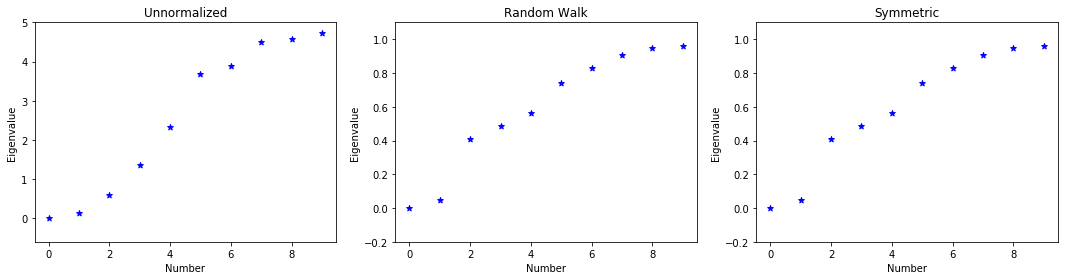

In [53]:
f.plot_eigenvalues(eigenvalues_list_imb, titles_list, ylim_list_imb, "figures/31-imb_data", n=10)

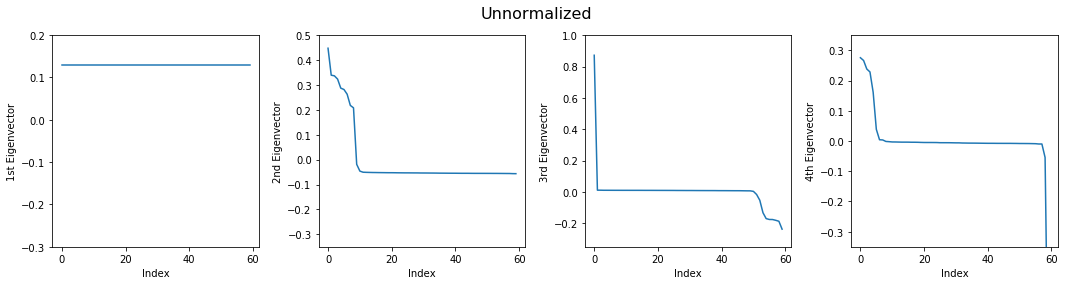

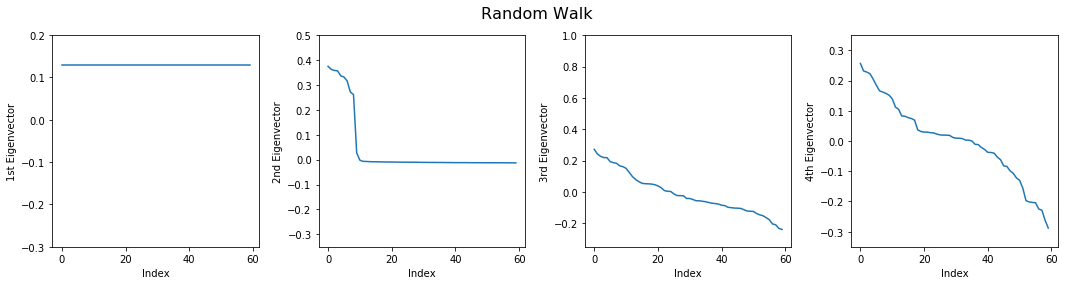

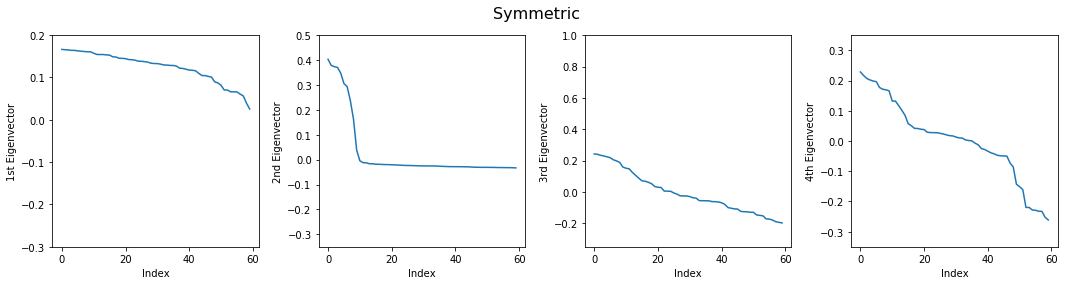

In [54]:
ylim_list_imb =[(-0.3, 0.2), (-0.35, 0.5), (-0.35, 1), (-0.35, 0.35)]
f.plot_eigenvectors(titles_list, eigenvectors_list_imb, ylim_list_imb,
                    "figures/32-line_plot_imb", plot_type="plot")

## B. Detecting the number of clusters - hirarchical organizations in the data set

In [55]:
#Create data points
Npts_imb = 100
Nclusters = 4
np.random.seed(1991)
data_coordinates = np.random.normal(loc=0.0, scale=1.0, size=(Npts_imb, 2))

#Assign randomly each datapoint to a cluster
labels = np.random.choice(list(range(Nclusters)),size=Npts_imb,replace=True, p=[0.35,0.15,0.35,0.15])

#Assign each cluster a mean.
data_means = np.zeros((4,2))
data_means[0,] = [6.5,2.5]
data_means[1,] = [6.5,9.5]
data_means[2,] = [-5,2]
data_means[3,] = [-6,8.58]
#Shift the points towards the mean
clusterd_data =data_coordinates+data_means[labels,]

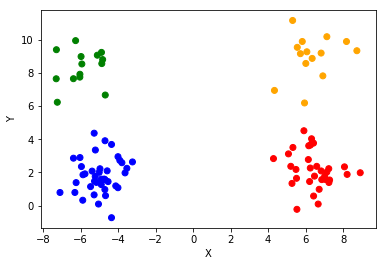

In [56]:
#Plot the data with original labels
f.scatter_plot_data_set(clusterd_data, labels, "figures/05-hirarchical_data")

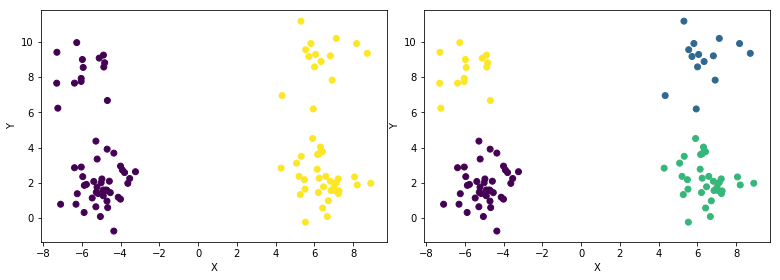

In [57]:
#K-means performance before the change of representation of the data:
kmeans_non_hirarchical = KMeans(n_clusters=2,random_state=0).fit(clusterd_data)
kmeans_hirarchical = KMeans(n_clusters=4,random_state=0).fit(clusterd_data)

fig = plt.figure(figsize=(11, 4))

#Plot data
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.scatter(clusterd_data[:,0],clusterd_data[:,1],c=kmeans_non_hirarchical.labels_)
plt.xlabel("X")
plt.ylabel("Y")

#Plot sorted eigenvectors
plt.subplot(1, 2, 2)
plt.tight_layout()
plt.scatter(clusterd_data[:,0],clusterd_data[:,1],c=kmeans_hirarchical.labels_)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [58]:
W_imbalanced_data = f.adjacency_matrix(clusterd_data, sigma=10)

#Unnormalized graph Laplacian
eigenvalues_unnorm_h, eigenvectors_unnorm_h = la.eig(f.unnormalized_graph_Laplacian(W_imbalanced_data))
eigenvalues_unnorm_h = eigenvalues_unnorm_h.real
rearranged_unnorm_evals_h_data = f.rearrange_eigenvals(eigenvalues_unnorm_h, eigenvectors_unnorm_h)
rearranged_unnorm_vecs_h_data = f.rearrange_eigenvecs(rearranged_unnorm_evals_h_data, labels)
#Symmetric graph Laplacian
eigenvalues_sym_h, eigenvectors_sym_h = la.eig(f.normalized_graph_Laplacian(W_imbalanced_data, 
                                                                            matrix ="symmetric"))
eigenvalues_sym_h = eigenvalues_sym_h.real
rearranged_sym_evals_h_data = f.rearrange_eigenvals(eigenvalues_sym_h, eigenvectors_sym_h)
rearranged_sym_vecs_h_data = f.rearrange_eigenvecs(rearranged_sym_evals_h_data, labels)

##Random Walk graph Laplacian   
eigenvalues_rw_h, eigenvectors_rw_h = la.eig(f.normalized_graph_Laplacian(W_imbalanced_data,
                                                                          matrix ="rw"))
eigenvalues_rw_h = eigenvalues_rw_h.real
rearranged_rw_evals_h_data = f.rearrange_eigenvals(eigenvalues_rw_h, eigenvectors_rw_h)
rearranged_rw_vecs_h_data = f.rearrange_eigenvecs(rearranged_rw_evals_h_data, labels)

In [59]:
ylim_list =[(-0.6, 10), (-0.1, 1.1), (-0.1, 1.1)]
eigenvalues_list_h = f.eigenvalues_list([rearranged_unnorm_evals_h_data,
                                            rearranged_rw_evals_h_data,
                                            rearranged_sym_evals_h_data])

eigenvectors_list_h = f.eigenvectors_list([rearranged_unnorm_vecs_h_data,
                                            rearranged_rw_vecs_h_data,
                                            rearranged_sym_vecs_h_data])

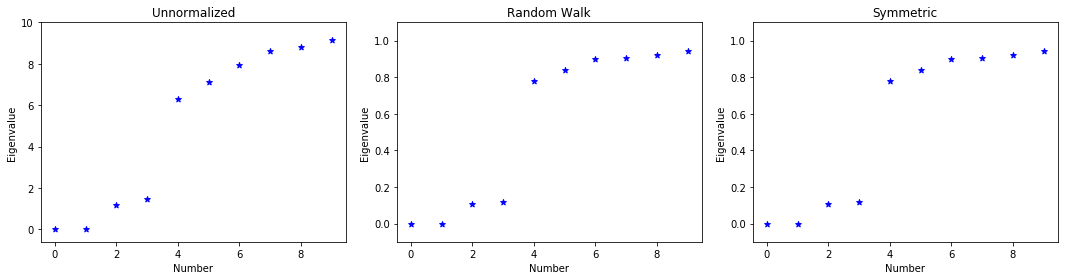

In [60]:
f.plot_eigenvalues(eigenvalues_list_h, titles_list, ylim_list, "figures/51-h_data_eigenspectrum", n=10)

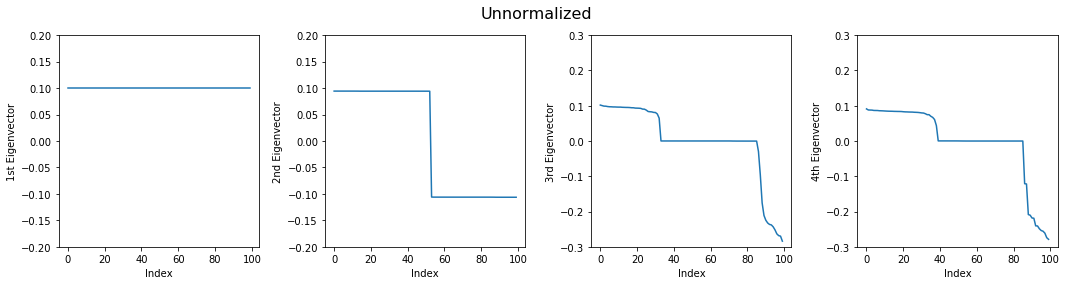

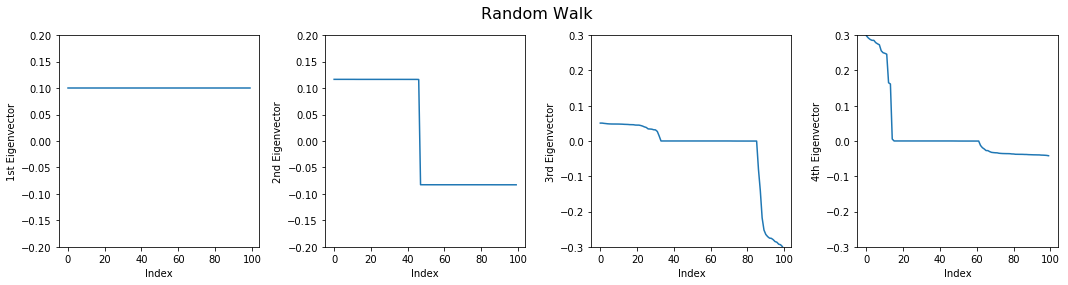

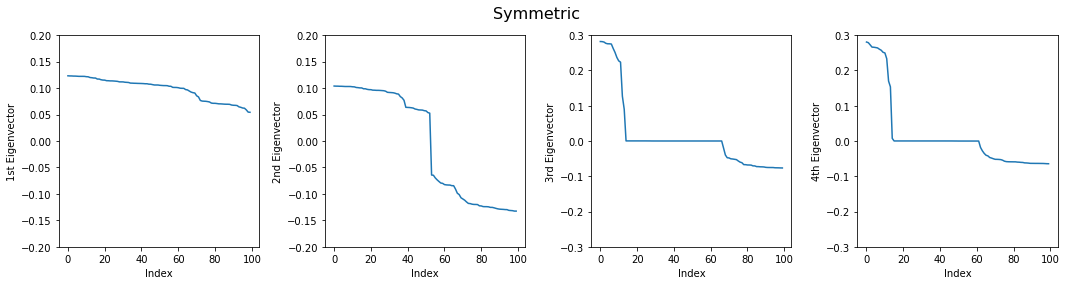

In [61]:
ylim_list_h =[(-0.2, 0.2), (-0.2, 0.2), (-0.3, 0.3), (-0.3, 0.3)]
f.plot_eigenvectors(titles_list, eigenvectors_list_h, ylim_list_h,
                    "figures/52-line_plot_h", plot_type="plot")
